In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

In [68]:
df = pd.read_csv("/home/antoine/workspace/mlops_reco_movies/airflow/data/raw/bronze/genome-tags.csv")
df.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


In [70]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

Missing values in each column:
tagId    0
tag      0
dtype: int64


In [71]:
df = df.rename(columns={"tagId":"tag_id"})
df.head()

,tag_id,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [72]:
nlp = spacy.load("en_core_web_sm")

def clean_tag(tag: str) -> str:
    doc = nlp(tag)
    return " ".join(
        token.text.lower()
        for token in doc
        if not token.is_punct and not token.is_stop
    )

In [73]:
df["clean_tag"]= df["tag"].apply(clean_tag)

df.head()

,tag_id,tag,clean_tag
0,1,007,007
1,2,007 (series),007 series
2,3,18th century,18th century
3,4,1920s,1920s
4,5,1930s,1930s


In [74]:
from collections import Counter

term_counts = Counter()
for doc in df["tag"]:
    term_counts.update(doc.split())

# Affiche les 10 termes les plus rares
print(term_counts.most_common()[:-10:-1])


[('zombies', 1), ('zombie', 1), ('wwii', 1), ('wuxia', 1), ('writers', 1), ("writer's", 1), ('ii', 1), ('i', 1), ('workplace', 1)]


Text(0, 0.5, 'Nombre de termes uniques')

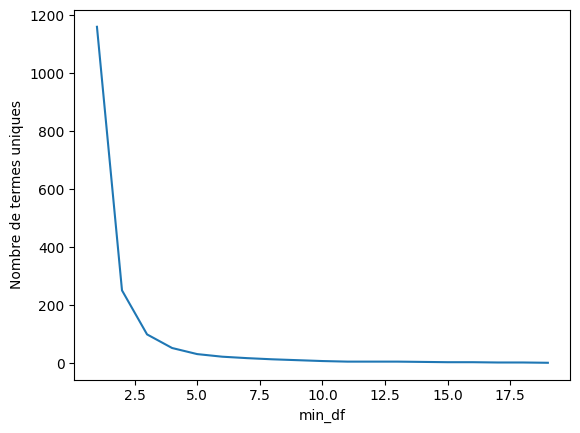

In [75]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer


min_dfs = range(1, 20)
n_features = [len(TfidfVectorizer(min_df=d).fit(df["tag"]).vocabulary_) for d in min_dfs]

plt.plot(min_dfs, n_features)
plt.xlabel('min_df')
plt.ylabel('Nombre de termes uniques')


Au regard de ce graphique, on observe que le nombre de termes uniques chute très rapidement lorsque min_df passe de 1 à environ 4, puis la courbe se stabilise et la diminution devient beaucoup plus lente.

Interprétation :

    Pour des valeurs de min_df entre 1 et 4, nous éliminons la grande majorité des termes rares (présents dans très peu de documents).

    Au-delà de 4, augmenter min_df n’élimine plus beaucoup de termes supplémentaires : la courbe s’aplatit.

Conclusion :
Une valeur de min_df comprise entre 3 et 5 semble intéressante :

    Elle permet de supprimer la majorité des termes très rares (souvent du bruit ou des coquilles).

    Elle conserve un nombre raisonnable de termes pour l’analyse sémantique.


In [76]:
vectorizer = TfidfVectorizer(min_df=2)
tfidf_matrix = vectorizer.fit_transform(df["clean_tag"])
df = df.iloc[list(vectorizer.vocabulary_.values())].reset_index(drop=True)
df.head(50)

,tag_id,tag,clean_tag
0,1,007,007
1,186,cartoon,cartoon
2,46,allegory,allegory
3,3,18th century,18th century
4,7,1960s,1960s
5,10,19th century,19th century
6,11,3d,3d
7,38,airplane,airplane
8,57,amnesia,amnesia
9,103,bad sequel,bad sequel


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tag_id     231 non-null    int64 
 1   tag        231 non-null    object
 2   clean_tag  231 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.5+ KB


In [78]:
import re

df["category"] = df["clean_tag"].apply(
    lambda x: "decade" if (re.search(r"\d{4}s?$", x) or re.search(r"\d{1,2}(st|nd|rd|th) century", x, re.IGNORECASE))
              else "concept"
)

In [79]:
df.head()

,tag_id,tag,clean_tag,category
0,1,007,007,concept
1,186,cartoon,cartoon,concept
2,46,allegory,allegory,concept
3,3,18th century,18th century,decade
4,7,1960s,1960s,decade


In [80]:
df.category.value_counts()

category
concept    222
decade       9
Name: count, dtype: int64

In [81]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(categories=[df["category"].unique().tolist()])
df["category_encoded"] = encoder.fit_transform(df[["category"]])
df.head(50)

,tag_id,tag,clean_tag,category,category_encoded
0,1,007,007,concept,0.0
1,186,cartoon,cartoon,concept,0.0
2,46,allegory,allegory,concept,0.0
3,3,18th century,18th century,decade,1.0
4,7,1960s,1960s,decade,1.0
5,10,19th century,19th century,decade,1.0
6,11,3d,3d,concept,0.0
7,38,airplane,airplane,concept,0.0
8,57,amnesia,amnesia,concept,0.0
9,103,bad sequel,bad sequel,concept,0.0
